In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from utilsCPD import *
import matplotlib.pyplot as plt

BATCH_SIZE  =32
mnist_transforms = transforms.Compose([transforms.ToTensor()])
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True, transform=mnist_transforms)
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [2]:
all_batches = []
all_labels =[]
torch.manual_seed(10)
for x,y in test_dataloader:
    bs = x.shape[0]
    all_batches.append(x.flatten().reshape(bs,784))
    all_labels.append(y)

all_batches = torch.cat(all_batches,dim=0)
all_labels = torch.cat(all_labels,dim=0)



data_c1 = all_batches[all_labels==1].detach().numpy()
data_c2 = all_batches[all_labels==7].detach().numpy()
data_c3 = all_batches[all_labels==9].detach().numpy()


#DATA = np.vstack((data_c1[:100,:],data_c2[400:600,:],data_c1[100:700,:]))
DATA = np.vstack((data_c1[:300],data_c2[:200],data_c1[:200]))


In [25]:
pd.DataFrame(DATA).head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
d=1000
mu1 = np.zeros(d)
mu2 = mu1.copy()
mu2[0] = 20


seg1 = np.random.multivariate_normal(mu1,np.eye(d),100)
seg2 = np.random.multivariate_normal(mu2,np.eye(d),500)
seg3 = np.random.multivariate_normal(mu1,np.eye(d),500)


DATA = np.vstack((seg1,seg2,seg3),dtype=np.float32)


In [12]:
import pandas as pd

pd.DataFrame(DATA).to_csv('DATA.csv')

#np.save('MNIST_dummy.npy',DATA)

In [20]:
from tqdm import tqdm
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
LENGHT = 50
train_dataloader_ts = DataLoader(TimeseriesDataset(DATA,LENGHT,split=0.5))
SWDs = []
test_stat  =[]
calibrated = False
t = 0
skip_count = 0  # To track the number of skipped iterations
segmentation ={}
segments=0
t0=int(LENGHT*0.5)-1
begin = time.time()
loss_segments = []
THETA = sample_theta_torch(DATA, 10000)
for i, d in enumerate(tqdm(train_dataloader_ts)):
    # Skip iterations if `skip_count` is active
    if skip_count > 0:
        skip_count -= 1
        continue

    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    #THETA = sample_theta_torch(x_ref, 5000)
    #print(THETA.dtype)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=4, device=device).mean(axis=0).detach().cpu().numpy()
    loss_segments.append(loss)
    SWDs.append(loss.mean())
    #test_stat.append(calc_statistic(0.05,x_cur.detach().cpu().numpy()))

    # Calibration phase
    if not calibrated:
        alpha_hat, beta_hat = mom_estimates(loss)
        #print('Calibration at {}'.format(i+LENGHT))
        #print(f"Calibration: alpha={alpha_hat}, beta={beta_hat}")
        calibrated = True
        lower_CI = [0]
        upper_CI = [0]
        cumsum = loss.mean()
        t = 1 
        #last_cal = 0 

    # Monitoring phase
    if calibrated:
        #last_cal += 1 
        l, u = gamma_conf_interval(t, alpha_hat, 1 / beta_hat, 0.99)
        lower_CI.append(l)
        upper_CI.append(u)
        cumsum += loss.mean()
        t += 1

        # Check if a change point is detected
        if cumsum >= u or cumsum <= l:
            print(f"Change Alarm at iteration {i + int(LENGHT*0.5)}")
            #print(mom_estimates(loss))
            #print(mom_estimates(np.hstack(loss_segments)))
            
            segmentation[segments] = {'t0':t0,'t1':i+int(LENGHT*0.5),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs}
            calibrated = False  # Reset calibration
            cumsum = 0
            t = 0
            skip_count = int(LENGHT*0.5)  # Skip the next 15 iterations
            SWDs = []
            segments+=1
            t0=i+LENGHT
            
        
segmentation[segments] = {'t0':t0,'t1':i+int(LENGHT*0.5),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs}
end = time.time()
print(end-begin)

 53%|█████▎    | 345/651 [00:01<00:00, 320.07it/s]

Change Alarm at iteration 294


 85%|████████▌ | 556/651 [00:02<00:00, 319.15it/s]

Change Alarm at iteration 501


100%|██████████| 651/651 [00:02<00:00, 267.56it/s]

2.47501540184021


In [5]:
def plot_statistic(ax,data,ax2):
    c = 0
    for key in data:
        segment = data[key]
        if c == 0:
            ax2.plot(np.arange(segment['t0'],segment['t1'],1),segment['SWDs'],color='black',lw=1.0,label='SWD')
            ax.plot(np.arange(segment['t0'],segment['t1'],1),segment['statistic'],color='blue',lw=1.5,label='Test statstic')
        else: 
            ax2.plot(np.arange(segment['t0'],segment['t1'],1),segment['SWDs'],color='black',lw=1.0)
            ax.plot(np.arange(segment['t0'],segment['t1'],1),segment['statistic'],color='blue',lw=1.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['lower'],color='blue',lw=1,alpha=0.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],color='blue',lw=1,alpha=0.5)
        ax.fill_between(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],segment['lower'],color='blue',alpha=0.2)
        c+=1

    return ax

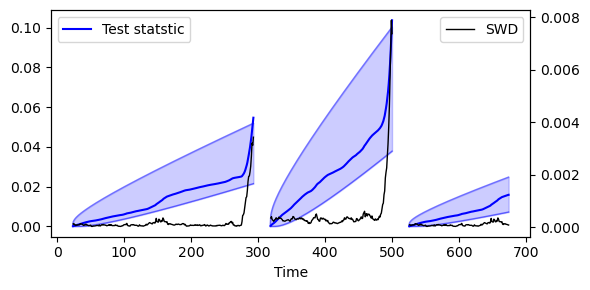

In [21]:
fig, ax = plt.subplots(figsize=(6,3))
ax2 = ax.twinx()
plot_statistic(ax,segmentation,ax2)
ax.legend()
ax2.legend()
ax.set_xlabel('Time')
fig.tight_layout()

 49%|████▉     | 319/651 [00:01<00:00, 413.17it/s]

Change detected at: 303 
 Initiate new segment


 81%|████████▏ | 530/651 [00:01<00:00, 396.92it/s]

Change detected at: 516 
 Initiate new segment


100%|██████████| 651/651 [00:01<00:00, 351.15it/s]


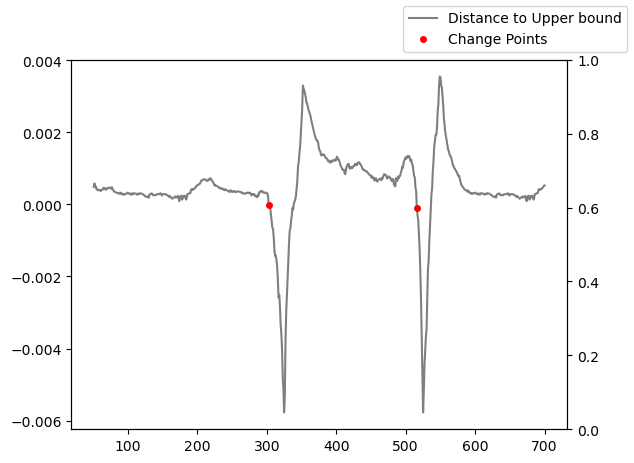

In [23]:
def gamma_conf_interval(step, a, b, confidence=0.95):
    alpha = step * a
    #lower_bound = gamma.ppf((1 - confidence), alpha, scale=b)
    upper_bound = gamma.ppf(1 - (1 - confidence), alpha, scale=b)
    return upper_bound

def CI_Calibration(alphas,betas,trend,significance=0.05):
    lookback = min(50,len(alphas))
    a = np.mean(alphas[-lookback:])
    b = np.mean(betas[-lookback:])
    return trend + gamma_conf_interval(1,a,1/b,1-significance)


loss_segments = []
alphas= []
betas =[]
LENGHT = 50
train_dataloader_ts = DataLoader(TimeseriesDataset(DATA,LENGHT,split=0.5))
THETA = sample_theta_torch(DATA, 5000)
TREND = []
cusum = 0
UPPER = []
first = True
CPS = {'loc':[],'value':[]}
CUMSUM = []
for i, d in enumerate(tqdm(train_dataloader_ts)):
    #THETA = sample_theta_torch(df_sequential.to_numpy(), 5000)
    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=4, device=device).mean(axis=0).detach().cpu().numpy()
    loss_segments.append(loss)
    cusum += loss.mean()
    CUMSUM.append(cusum)

    if i>0:
        if cusum >= UPPER[-1]:
            if first == True:
                print("Change detected at: {} \n Initiate new segment".format(i+LENGHT))
                CPS['loc'].append(i+LENGHT)
                CPS['value'].append(UPPER[-1]-cusum)
                first = False
        else:
            first = True
    
    TREND.append(cusum)
    #parameter estimation
    a_hat, b_hat = mom_estimates(loss)
    alphas.append(a_hat)
    betas.append(b_hat)
    #calc next UPPERBOUND
    UPPER.append(CI_Calibration(alphas,betas,TREND[-1],significance=0.05))


df = pd.DataFrame([l.mean() for l in loss_segments],columns=['SWD'])
CUMSUM = np.cumsum([l.mean() for l in loss_segments])
fig, ax = plt.subplots()
ax2 = ax.twinx()
#df.cumsum().iloc[1:].plot(ax=ax)
#ax.plot(CUMSUM,label='Cumulative sum')
#ax.plot(UPPER,color='red',label='Upper Bound')
t = np.arange(LENGHT+1,len(CUMSUM)+LENGHT,1)
ax.plot(t,np.subtract(UPPER[:-1],CUMSUM[1:]),label='Distance to Upper bound',color='black',alpha=0.5)
ax.plot(np.array(CPS['loc']),CPS['value'],'o',color='red',ms=4,label='Change Points')
fig.legend()



In [9]:
import pandas as pd

100%|██████████| 651/651 [00:01<00:00, 464.91it/s]


<Axes: >

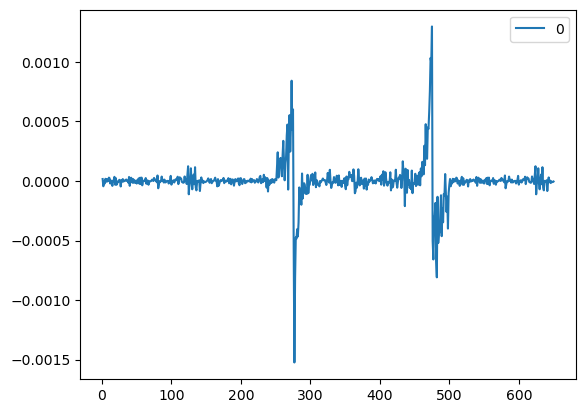

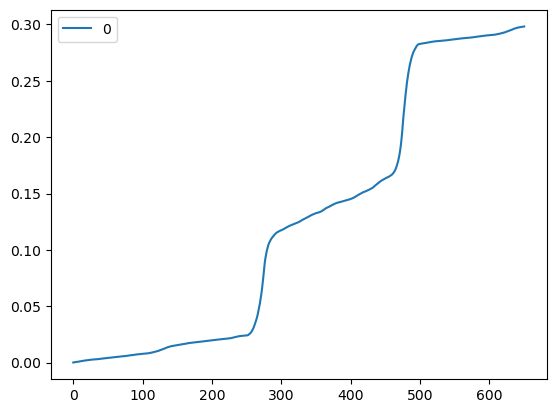

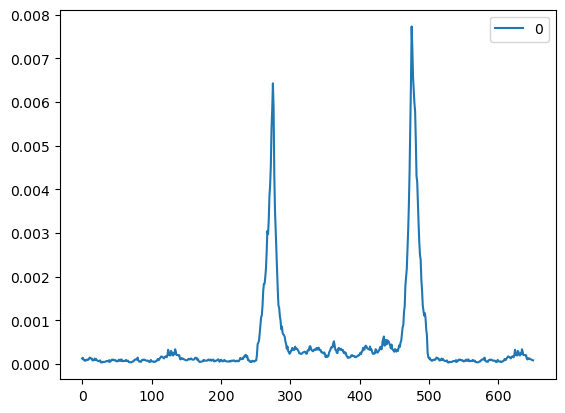

In [15]:
loss_segments = []
alphas= []
betas =[]
test_stat = []
THETA = sample_theta_torch(DATA, 5000)
for i, d in enumerate(tqdm(train_dataloader_ts)):
    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=4, device=device).mean(axis=0).detach().cpu().numpy()
    loss_segments.append(loss)
    a_hat, b_hat = mom_estimates(loss)
    alphas.append(a_hat)
    betas.append(b_hat)
    #test_stat.append(calc_statistic(0.05,x_cur.detach().cpu().numpy()))
    #SWDs.append(loss.mean())
df = pd.DataFrame([l.mean() for l in loss_segments])
df.diff().plot()
df.cumsum().plot()
df.plot()

In [11]:
df.to_csv('df_out.csv')

In [53]:
import numpy as np
from scipy.spatial.distance import pdist

def compute_diameter_multidimensional(sample):
    """
    Computes the diameter of the support of a given multi-dimensional sample set.

    Parameters:
        sample (array-like): A 2D array where each row is a point in n-dimensional space.

    Returns:
        float: The diameter of the support.
    """
    # Ensure the sample is a NumPy array
    sample = np.array(sample)
    
    # Compute all pairwise distances
    distances = pdist(sample, metric='euclidean')
    
    # Find the maximum distance
    diameter = np.max(distances)
    
    return diameter


#diam = compute_diameter_multidimensional(df_sequential.iloc[:20])
#compute_diameter_multidimensional(df_sequential.iloc[20:40])

def calc_statistic(alpha,samples):
    n= len(samples)
    diam = compute_diameter_multidimensional(samples)
    return diam*np.sqrt(np.log(2/alpha))/np.sqrt(n)*2*np.sqrt(2/n*samples.var().sum() + np.linalg.norm(samples.mean(axis=1))**2) + 2*n**(-0.5)

In [16]:
varbound_lower = []
varbound_upper = []
start_ind = 0
skip_count = 0
cps = []
new_seg = []
for i in range(2,len(loss_segments)):
    if skip_count >0:
        skip_count-=1
        varbound_lower.append(0)
        varbound_upper.append(0)

        
        continue
    a,b = estimate_parameter_CI(np.vstack(loss_segments[start_ind:i]),0.05)
    

    bound_var = 2*(a[0]/b[1]**2)**0.5
    if bound_var >= loss_segments[i].mean():

        varbound_lower.append(bound_var)
        varbound_upper.append(2*(a[1]/b[0]**2)**0.5)
    else:
        cps.append(i)
        skip_count = 50
        varbound_lower.append(0)
        varbound_upper.append(0)
        start_ind = i + skip_count
        new_seg.append(start_ind)
        print(start_ind)

307
516


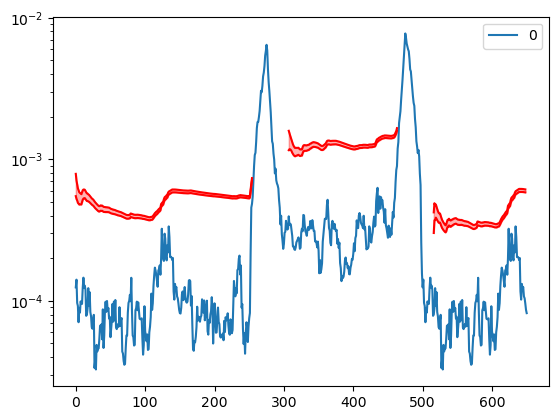

In [17]:
df = pd.DataFrame([l.mean() for l in loss_segments])
fig,ax = plt.subplots()
df.plot(ax=ax)
ax.set_yscale('log')

t = np.array(range(len(varbound_upper)))

plot_segments(ax,t,cps,new_seg,varbound_lower,varbound_upper)
# ax.plot(t[:cps[0]-2],np.array(varbound_lower)[:cps[0]-2],color='red')
# ax.plot(t[:cps[0]-2],np.array(varbound_upper)[:cps[0]-2],color='red')
# ax.fill_between(t[:cps[0]-2],np.array(varbound_lower)[:cps[0]-2],np.array(varbound_upper)[:cps[0]-2],alpha=0.3,color='red');

# ax.plot(t[new_seg[0]:cps[1]-2],np.array(varbound_lower)[new_seg[0]:cps[1]-2],color='red')
# ax.plot(t[new_seg[0]:cps[1]-2],np.array(varbound_upper)[new_seg[0]:cps[1]-2],color='red')
# ax.fill_between(t[new_seg[0]:cps[1]-2],np.array(varbound_lower)[new_seg[0]:cps[1]-2],np.array(varbound_upper)[new_seg[0]:cps[1]-2],alpha=0.3,color='red');

# ax.plot(t[new_seg[1]:],np.array(varbound_lower)[new_seg[1]:],color='red')
# ax.plot(t[new_seg[1]:],np.array(varbound_upper)[new_seg[1]:],color='red')
# ax.fill_between(t[new_seg[1]:],np.array(varbound_lower)[new_seg[1]:],np.array(varbound_upper)[new_seg[1]:],alpha=0.3,color='red');



In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_segments(ax, t, cps, new_seg, varbound_lower, varbound_upper, color='red', alpha=0.3):
    """
    Plots segments with changepoints and fills the bounds between varbound_lower and varbound_upper.

    Parameters:
        ax : matplotlib.axes.Axes
            The matplotlib axis object to plot on.
        t : array-like
            The time array corresponding to the data.
        cps : list
            A list of changepoints indices.
        new_seg : list
            A list of starting indices for new segments after waiting 50 values.
        varbound_lower : list or array-like
            The lower bound values for the variable.
        varbound_upper : list or array-like
            The upper bound values for the variable.
        color : str, optional
            The color for the plots and shaded areas (default is 'red').
        alpha : float, optional
            The alpha transparency for the shaded area (default is 0.3).

    Returns:
        None
    """
    # Plot the first segment
    ax.plot(t[:cps[0]-2], np.array(varbound_lower)[:cps[0]-2], color=color)
    ax.plot(t[:cps[0]-2], np.array(varbound_upper)[:cps[0]-2], color=color)
    ax.fill_between(t[:cps[0]-2], 
                    np.array(varbound_lower)[:cps[0]-2], 
                    np.array(varbound_upper)[:cps[0]-2], 
                    alpha=alpha, color=color)

    # Loop over subsequent segments
    for i in range(len(new_seg)):
        if i < len(cps) - 1:  # Handle intermediate segments
            start = new_seg[i]
            end = cps[i + 1] - 2
            ax.plot(t[start:end], np.array(varbound_lower)[start:end], color=color)
            ax.plot(t[start:end], np.array(varbound_upper)[start:end], color=color)
            ax.fill_between(t[start:end], 
                            np.array(varbound_lower)[start:end], 
                            np.array(varbound_upper)[start:end], 
                            alpha=alpha, color=color)
        else:  # Handle the last segment
            start = new_seg[i]
            ax.plot(t[start:], np.array(varbound_lower)[start:], color=color)
            ax.plot(t[start:], np.array(varbound_upper)[start:], color=color)
            ax.fill_between(t[start:], 
                            np.array(varbound_lower)[start:], 
                            np.array(varbound_upper)[start:], 
                            alpha=alpha, color=color)


In [71]:
len(loss_segments)

476

In [28]:
10**-1

0.1

In [26]:
1/25

0.04

In [246]:
pd.DataFrame(np.hstack([df.values,df.diff().values])).cov()

,0,1
0,0.869812,0.008939
1,0.008939,0.017761


In [24]:
diam = np.linalg.norm(x_cur.detach().cpu().numpy(),axis=1).max()

In [25]:
(diam*np.sqrt(np.log(2/0.05))/np.sqrt(25))*2*(2/25*np.linalg.norm(x_cur.detach().cpu().numpy(),axis=1).mean())**0.5

5.442217253653282

<Axes: >

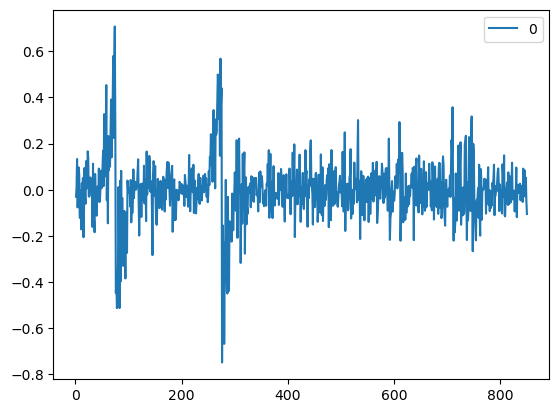

In [184]:
df.diff().plot()

In [142]:
2*1/(0.5)**2

8.0

22.22222222222222


0    20.538902
dtype: float64

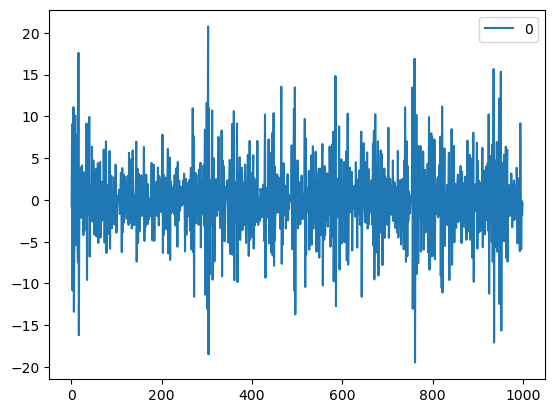

In [222]:
beta=0.3
RV = np.random.gamma(1,1/beta,1000)

print(2/(0.3)**2)
pd.DataFrame(RV).diff().plot()

pd.DataFrame(RV).diff().var()

In [62]:

df = pd.DataFrame([l.mean() for l in loss_segments])

In [36]:
alpha_hat

1.2759741010219752

In [50]:
df.std()

0    0.927461
dtype: float32

<Axes: >

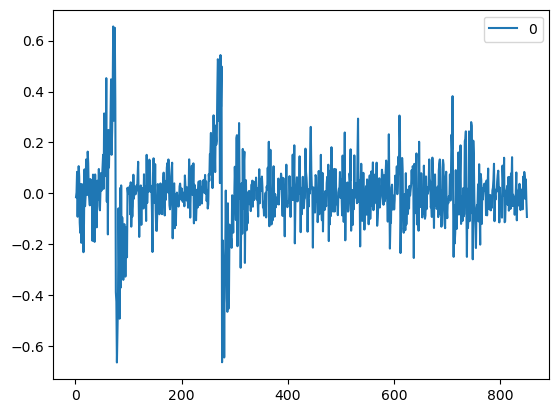

In [63]:
df.diff().plot()

 12%|█▏        | 20/171 [00:00<00:00, 191.34it/s]

1.335048022141591 75.97498


 47%|████▋     | 80/171 [00:00<00:00, 241.23it/s]

Change Alarm at 95


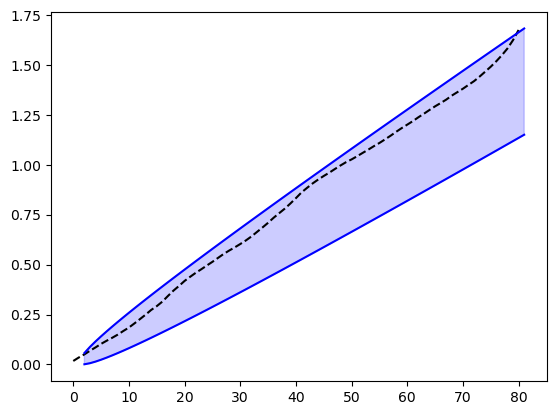

In [162]:
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader_ts = DataLoader(TimeseriesDataset(DATA,30,split=0.5))
SWDs = []

calibrated = False
t=0
for i , d in enumerate(tqdm(train_dataloader_ts)):
    x_ref, x_cur = d[0].squeeze(0).to(device),d[1].squeeze(0).to(device)
   
    THETA = sample_theta_torch(x_ref,1000)
    loss = project_and_calc_dist_torch(x_ref,x_cur,THETA,p=2,device=device).mean(axis=0).detach().cpu().numpy()

    
    
    SWDs.append(loss.mean())

    if not calibrated:
        alpha_hat,beta_hat = mom_estimates(loss)
        print(alpha_hat,beta_hat)
        calibrated = True
        lower_CI = [0]
        upper_CI  = [0]
        cumsum = loss.mean()
        t+=1

    if calibrated:
        l,u = gamma_conf_interval(i,alpha_hat,1/beta_hat,0.95)
        lower_CI.append(l)
        upper_CI.append(u)
        ###check change point
        cumsum+=loss.mean()
        if cumsum >= u or cumsum <= l:
            print("Change Alarm at {}".format(i+15))
            break
        


plt.plot(np.cumsum(SWDs),'--',color='black')
plt.plot(upper_CI,color='blue')

plt.plot(lower_CI,color='blue')
plt.fill_between(range(len(upper_CI)),upper_CI,lower_CI,color='blue',alpha=0.2);

  6%|▌         | 10/171 [00:00<00:00, 195.94it/s]

Warmup complete. Estimated parameters: alpha_hat=1.3129945745152551, beta_hat=76.23937225341797
Change Alarm at 25


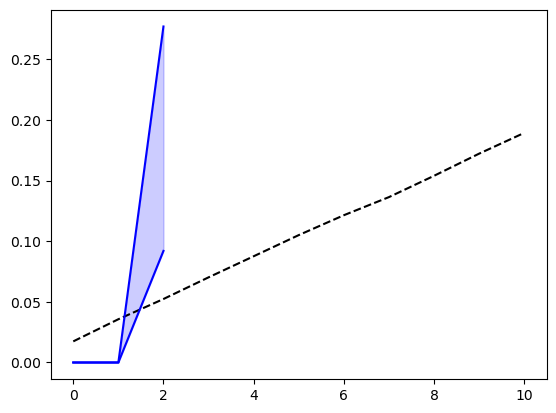

In [118]:
SWDs = []

calibrated = False
warmup = True
warmup_losses = []  # List to store losses during the warmup phase
warmup_steps = 10   # Number of steps for the warmup phase

for i, d in enumerate(tqdm(train_dataloader_ts)):
    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    THETA = sample_theta_torch(x_ref, 1000)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=2, device=device).mean(axis=0).detach().cpu().numpy()
    
    SWDs.append(loss.mean())

    if warmup and i < warmup_steps:
        # Collect losses during the warmup phase
        warmup_losses.append(loss)
        lower_CI = [0]
        upper_CI = [0]
        continue  # Skip the rest of the loop until warmup is complete
    
    if warmup and i == warmup_steps:
        # End of the warmup phase: Estimate parameters and start calibration
        warmup = False
        calibrated = True
        alpha_hat, beta_hat = mom_estimates(np.array(warmup_losses))  # Use collected warmup losses
        lower_CI.append(0)
        upper_CI.append(0)
        cumsum = np.mean(warmup_losses)  # Initialize cumulative sum with warmup mean
        print(f"Warmup complete. Estimated parameters: alpha_hat={alpha_hat}, beta_hat={beta_hat}")

    if calibrated:
        l, u = gamma_conf_interval(i , alpha_hat, 1 / beta_hat, 0.95)
        lower_CI.append(l)
        upper_CI.append(u)
        ### Check change point
        cumsum += loss.mean()
        if cumsum >= u or cumsum <= l:
            print(f"Change Alarm at {i + 15}")
            break


plt.plot(np.cumsum(SWDs),'--',color='black')
plt.plot(upper_CI,color='blue')

plt.plot(lower_CI,color='blue')
plt.fill_between(range(len(upper_CI)),upper_CI,lower_CI,color='blue',alpha=0.2);